## Ildebrando Magnani

Homework 11:

Replicate Fig. 1 of “Stochastic Stability in Monotone Economies”, by Takashi Kamihigashi, John Stachurski.

* Use fitted policy function iteration to solve for optimal policies

Note: There is some bug for which changing the value of beta doesn't cause any change in the optimal consumption policy. Still trying to fix it.

Thanks to Professor Stachurski for some important corrections he made to "compute_value_function" and "T_sigma" operators.

In [274]:
% matplotlib inline
import numpy as np
from numpy import interp
from scipy.optimize import fminbound
from quantecon.compute_fp import compute_fixed_point
import matplotlib.pyplot as plt

Here I define all the parameters of the model.

In [275]:
a = 1
b = 2
c = 20
d = 1
theta = 0.5
gamma = 0.9
alpha = 0.5
grid_max = 8
grid_size = 120
grid = np.linspace(1e-6, grid_max, grid_size)
shocks = np.exp(np.random.normal(-1, 0.2, 500))
beta_vals = np.linspace(0.945, 0.99, 4)

Below I define the utility function.

In [276]:
def U(c):
    return 1 - np.exp(-theta * c**gamma)

Below I define the income process "f" (production function * stochastic noise).

In [277]:
def f(k, eps_noise):
    return (k**alpha * (a + (b - a)/(1 + np.exp(-c * (k - d))))) * eps_noise

Now define an operator that finds the argmax of a function g.

In [278]:
def max_operator(g, lower_b, upper_b):
    return fminbound(lambda x: -g(x), lower_b, upper_b)

Define the operator T_sigma that we will later iterate to find the value function corresponding to a given policy function.

In [279]:
def T_sigma(sigma, w_fn, beta):
    new_w = np.empty_like(grid)
    for i, y in enumerate(grid):
        new_w[i] = U(sigma(y)) + beta * np.mean(w_fn(f(y - sigma(y), shocks)))
    interp_new_w = lambda x: np.interp(x, grid, new_w)
    return interp_new_w

In [280]:
w_fn = lambda z: np.interp(z, grid, np.sqrt(grid))

In [281]:
def sigma(y):
    return y

In [282]:
w_new = T_sigma(sigma, w_fn, beta=0.99)

In [283]:
w_new(5)

0.8819467273776012

Create a function that iterates the T_sigma operator until convergence occurs. This returns the value function corresponding to a given policy.

In [284]:
def compute_value_function(sigma, v, beta, tol=1e-5, max_iter=1000):
    i = 0
    while i < max_iter:
        w_new = T_sigma(sigma, v, beta)
        error = np.max(np.abs(w_new(grid) - v(grid)))
        if error < tol:
            break
        T_new = v
        i += 1
    return w_new

In [285]:
w_test = compute_value_function(sigma, w_fn, beta=0.99)

In [286]:
w_test(3.4)

0.7787705922484922

Now I want to define an operator that returns the w-greedy policy by taking the argmax of U(c) + beta * E(w(f(y - c, shocks))).

In [287]:
def compute_greedy_policy(w, beta):
    greedy_vals = np.empty_like(grid)
    for i, y in enumerate(grid):
        g = lambda c: U(c) + beta * np.mean(w(f(y - c, shocks)))
        greedy_vals[i] = max_operator(g, 0, y)
    interp_greedy = lambda x: np.interp(x, grid, greedy_vals)
    return interp_greedy

In [288]:
greedy_test = compute_greedy_policy(w, beta=0.99)

In [289]:
greedy_test(3.6)

2.392537330475774

Below I implement Howard's policy iteration method to find the optimal policy.

In [290]:
def compute_optimal_policy(sigma, w_fn, beta, tol=1e-5, max_iter=1000):
    i = 0
    while i < max_iter:
        v_sigma = compute_value_function(sigma, w_fn, beta)
        greedy = compute_greedy_policy(v_sigma, beta)
        error = np.max(np.abs(greedy(grid) - sigma(grid)))
        if tol < error:
            break
        i += 1
        greedy = sigma
    return greedy

In [291]:
sigma_optimal_test = compute_optimal_policy(sigma, w_fn, beta=0.99, tol=1e-5, max_iter=1000)

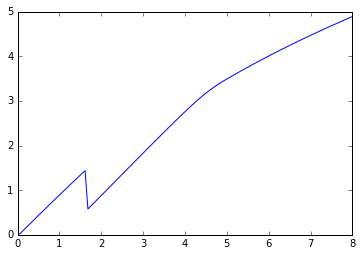

In [292]:
sigma_optimal_test(grid)
plt.plot(x, sigma_optimal_test(grid))

In [293]:
def production_function(k):
    return (k**alpha * (a + (b - a)/(1 + np.exp(-c * (k - d)))))

Plotting:

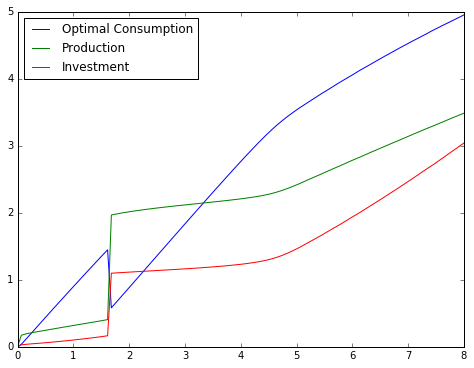

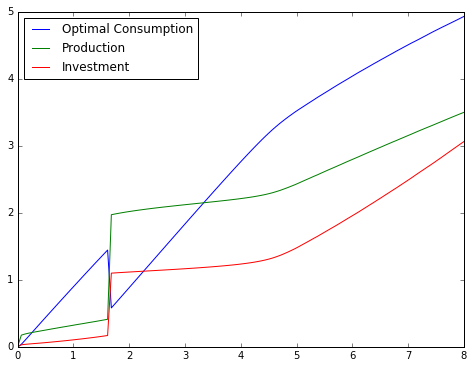

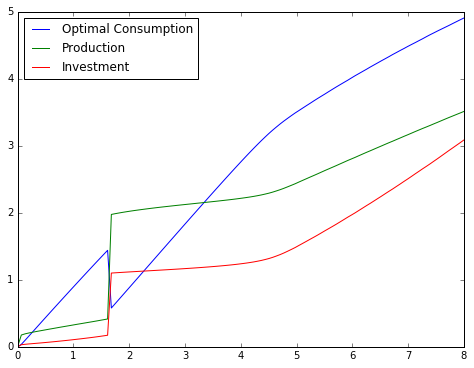

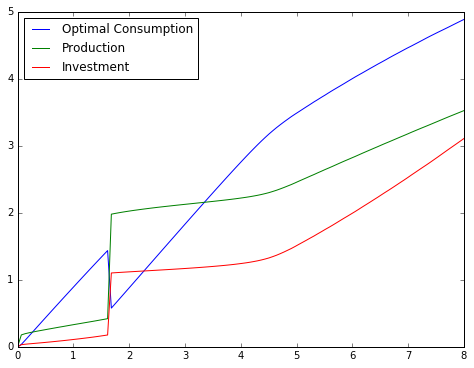

In [294]:
x = np.linspace(0, 8, len(grid))

for i, beta in enumerate(beta_vals):
    fig, ax = plt.subplots(figsize=(8,6))
    opt_sigma = compute_optimal_policy(sigma, w_fn, beta, tol=1e-5, max_iter=1000)
    production = production_function(grid - opt_sigma(grid))
    investment = grid - opt_sigma(grid)
    ax.plot(x, opt_sigma(grid), label="Optimal Consumption")
    ax.plot(x, production, label="Production")
    ax.plot(x, investment, label="Investment")
    plt.legend(loc='higher left')
    plt.show()